## R "magic"

- extension to the jupyter notebook
- defined the "magic" `%%R` and `%R`

In [1]:
%load_ext rpy2.ipython

---

- R code can be mixed with Python code
- Cells with R code are prefixed with `%%R`
- The R output is returned

In [2]:
%%R

R.version


               _                                                 
platform       x86_64-pc-linux-gnu                               
arch           x86_64                                            
os             linux-gnu                                         
system         x86_64, linux-gnu                                 
status         Under development (unstable)                      
major          3                                                 
minor          3.0                                               
year           2016                                              
month          03                                                
day            03                                                
svn rev        70270                                             
language       R                                                 
version.string R Under development (unstable) (2016-03-03 r70270)
nickname       Unsuffered Consequences                           


---

In [3]:
%%R
## Dobson (1990) Page 93: Randomized Controlled Trial :
counts <- c(18,17,15,20,10,20,25,13,12)
outcome <- gl(3,1,9)
treatment <- gl(3,3)
print(d.AD <- data.frame(treatment, outcome, counts))
glm.D93 <- glm(counts ~ outcome + treatment, family = poisson())
anova(glm.D93)

  treatment outcome counts
1         1       1     18
2         1       2     17
3         1       3     15
4         2       1     20
5         2       2     10
6         2       3     20
7         3       1     25
8         3       2     13
9         3       3     12
Analysis of Deviance Table

Model: poisson, link: log

Response: counts

Terms added sequentially (first to last)


          Df Deviance Resid. Df Resid. Dev
NULL                          8    10.5814
outcome    2   5.4523         6     5.1291
treatment  2   0.0000         4     5.1291


---

### Communicating with the outside world (Python)

In [4]:
FILENAME = "Pothole_Repair_Requests.csv"

In [5]:
%%R -i FILENAME
print(FILENAME)

[1] "Pothole_Repair_Requests.csv"


In [6]:
%%R -o result
result <- 2*pi

---

# Data table

- Running code in 2 languages is nice...
- ...but code objects should be passed back and forth
- The "data table" is:
  * a high-level data structure
  * common (in concept) across Python, R (and SQL, etc...)

---

## Reading from a CSV file

### Pandas

In [7]:
# FILENAME = "Pothole_Repair_Requests.csv"
import pandas
pdataf = pandas.read_csv(FILENAME)

---

### R "magic"

In [8]:
%%R -i FILENAME
dataf <- read.csv(FILENAME)
str(dataf)

'data.frame':	6161 obs. of  8 variables:
 $ Request.ID    : Factor w/ 6160 levels "","REQ194189",..: 2 3 4 5 6 7 8 9 10 11 ...
 $ Status        : Factor w/ 5 levels "","Assigned",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ Action.Type   : Factor w/ 2 levels "","Repair Pothole in Street": 2 2 2 2 2 2 2 2 2 2 ...
 $ Date.Submitted: Factor w/ 2670 levels "","01/01/2013 12:00:00 AM",..: 69 69 69 69 69 69 69 69 81 81 ...
 $ Date.Completed: Factor w/ 1922 levels "","01/02/2012 12:00:00 AM",..: 55 55 55 55 55 55 55 55 74 74 ...
 $ Address       : Factor w/ 3558 levels "","1 Aberdeen Ave\nCambridge, MA\n(42.37734449700048, -71.14744958699964)",..: 3154 3500 3094 3448 2247 3398 2571 3451 3197 3400 ...
 $ Platform      : Factor w/ 8 levels "","0","Android",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Submitted.By  : Factor w/ 48 levels "","anagle","apedro",..: 7 7 7 7 7 7 7 7 7 7 ...


---

### R from Python

In [9]:
from rpy2.robjects.packages import importr
utils = importr('utils')

---

In [10]:
dataf = utils.read_csv(FILENAME)

In [11]:
print(dataf.colnames)

[1] "Request.ID"     "Status"         "Action.Type"    "Date.Submitted"
[5] "Date.Completed" "Address"        "Platform"       "Submitted.By"  



---

# GGplot2 graphics

Build graphics with
- "mappings": associate "columns" with visual dimensions
- "layers"  : additive declarations to build a figure

In [12]:
%%R
options(bitmapType="cairo")

---

### First in R:

Map the column `Status` to the visual dimension `x`.

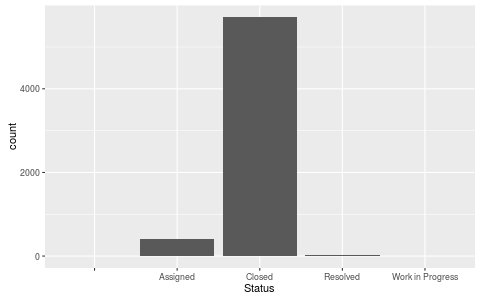

In [13]:
%%R -i dataf -h 300
#The height of the figure is specified with "-h 300"
library(ggplot2)

p = ggplot(dataf) + 
    geom_bar(aes(x=Status))
print(p)

---

- Map the column `Status` to the visual dimension `x`.
- Map the column `Platform` to the visual dimension `y`.

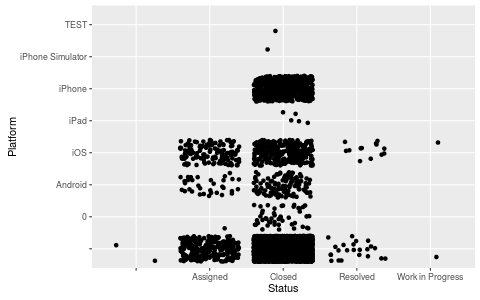

In [14]:
%%R -i dataf -h 300
p = ggplot(dataf) + 
    geom_jitter(aes(x=Status, y=Platform))
print(p)

---

- Map the column `Status` to the visual dimension `x`.
- Map the column `Platform` to the visual dimension `y`.
- Map the column `Action.Type` to the visual dimension `color`.

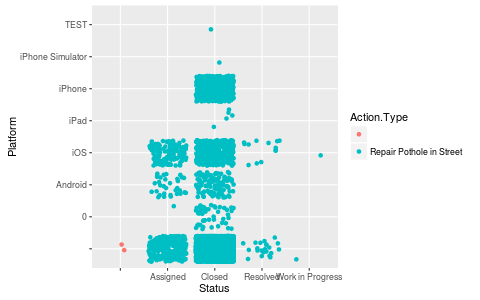

In [15]:
%%R -i dataf -h 300
p = ggplot(dataf) + 
    geom_jitter(aes(x=Status, y=Platform, color=Action.Type))
print(p)

---

## Interlude: namespaces in R

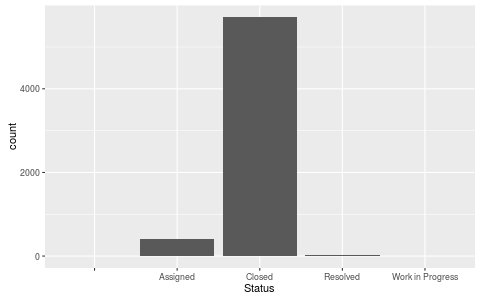

In [16]:
%%R -i dataf -h 300
library(ggplot2)

p = ggplot2::ggplot(dataf) + 
    ggplot2::geom_bar(ggplot2::aes(x=Status))
print(p)

---

## R from Python

In [17]:
%%R
p = ggplot2::ggplot(dataf) + 
    ggplot2::geom_bar(ggplot2::aes(x=Status))

In [18]:
from rpy2.robjects.lib import ggplot2
import rpy2.ipython.ggplot as igp

In [19]:
gp = ggplot2
p = (gp.ggplot(dataf) + 
     gp.geom_bar(gp.aes_string(x='Status')))
type(p)

rpy2.robjects.lib.ggplot2.GGPlot

---

In [20]:
from IPython import display
import tempfile
import io
import os
from rpy2 import robjects

def display_ggplot2(gg, width=800, height=400):
    """ Hook to render ggplot2 figures"""
    fn = tempfile.mktemp()
    try:
        robjects.r("png")(fn, type="cairo-png", 
                          width=width, height=height, 
                          antialias="subpixel")
        robjects.r("print")(gg)
        robjects.r("dev.off()")
        b = io.BytesIO()
        with open(fn, 'rb') as fh:
            b.write(fh.read())
    finally:
        if os.path.exists(fn):
            os.unlink(fn)
    data = b.getvalue()
    ip_img = display.Image(data=data, format='png', embed=True)
    return ip_img._repr_png_()

# register display func with PNG formatter:
png_formatter = get_ipython().display_formatter.formatters['image/png']
dpi = png_formatter.for_type(ggplot2.GGPlot, display_ggplot2)

---

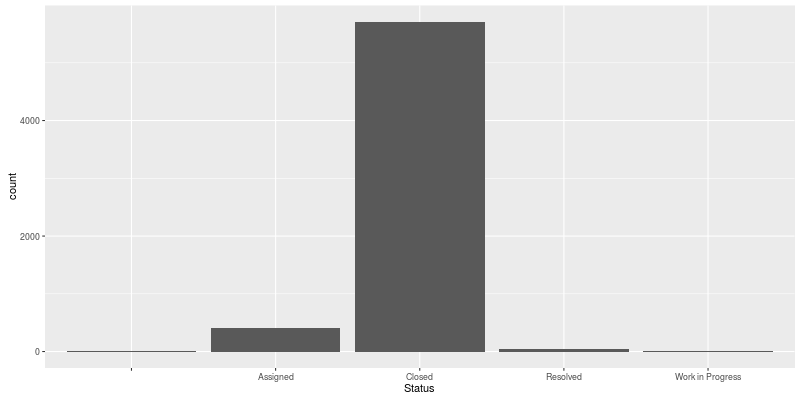

In [21]:
p

---

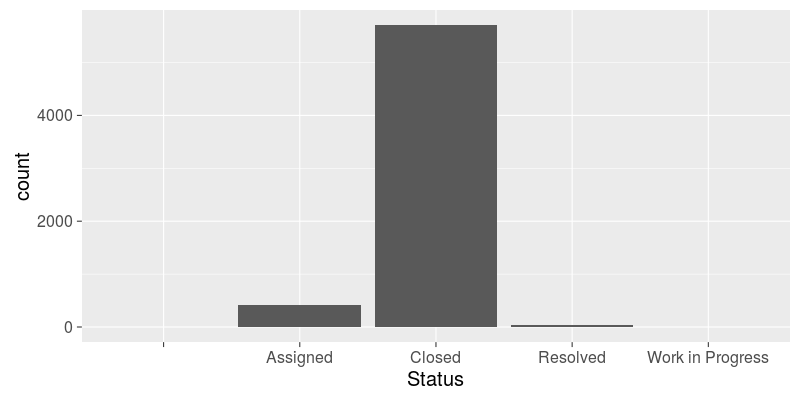

In [22]:
p + gp.theme_gray(base_size=20)

---

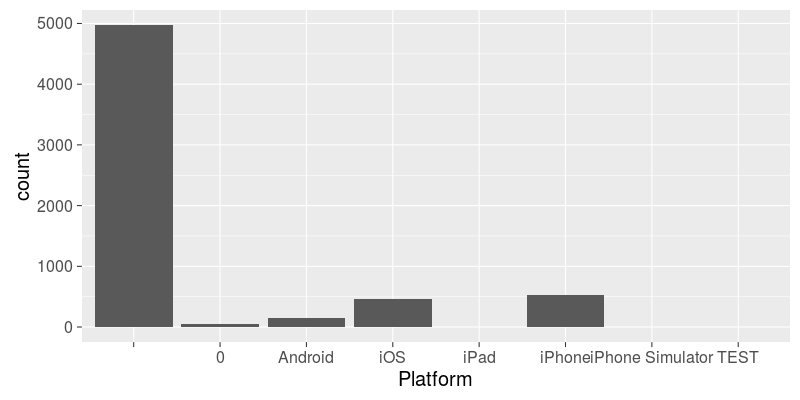

In [23]:
p = (gp.ggplot(dataf) + 
     gp.geom_bar(gp.aes_string(x='Platform')) +
     gp.theme_gray(base_size=20))
p

---

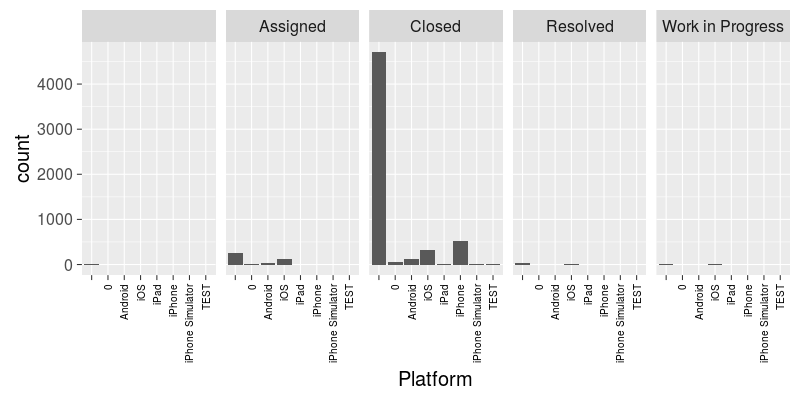

In [24]:
p = (gp.ggplot(dataf) + 
     gp.geom_bar(gp.aes_string(x='Platform')) +
     gp.facet_grid('~Status') +
     gp.theme_gray(base_size=20) +
     gp.theme(**{'axis.text.x': gp.element_text(angle = 90, hjust = 1)}))
p

---

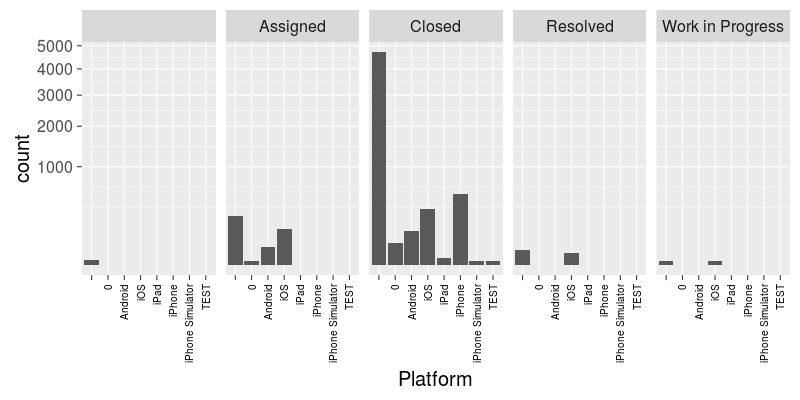

In [25]:
p + gp.scale_y_sqrt()

---

# dplyr

In [26]:
next(dataf[5].iter_labels())

'Concord Ave\nCambridge, MA\n(42.38675507400046, -71.14068255199965)'

---

In [27]:
from rpy2.robjects.lib import dplyr

---

In [28]:
ddataf = dplyr.DataFrame(dataf)

---

In [29]:
import re
s_pat_float = '[+-]?[0-9.]+'
s_pat_coords = '.+\((%s), (%s)\)$' % (s_pat_float, s_pat_float)
pat_coords = re.compile(s_pat_coords,
                        flags=re.DOTALL)
from rpy2.robjects import NA_Real
def extract_coords(address):
    m = pat_coords.match(address)
    if m is None:
        return (NA_Real, NA_Real)
    else:
        return tuple(float(x) for x in m.groups())

---

In [30]:
extract_coords(next(ddataf[5].iter_labels()))

(42.38675507400046, -71.14068255199965)

---

In [31]:
from rpy2.robjects.vectors import FloatVector
from rpy2.robjects import globalenv

globalenv['extract_lat'] = \
    lambda v: FloatVector(tuple(extract_coords(x)[0] for x in v))

globalenv['extract_long'] = \
    lambda v: FloatVector(tuple(extract_coords(x)[1] for x in v))

ddataf = (ddataf.
          mutate(lat='extract_lat(as.character(Address))',
                 long='extract_long(as.character(Address))',
                 date_submitted='as.POSIXct(Date.Submitted, format="%m/%d/%Y %H:%M:%S")',
                 date_completed='as.POSIXct(Date.Completed, format="%m/%d/%Y %H:%M:%S")').
          mutate(days_to_fix='as.numeric(date_completed - date_submitted, unit="days")'))

---

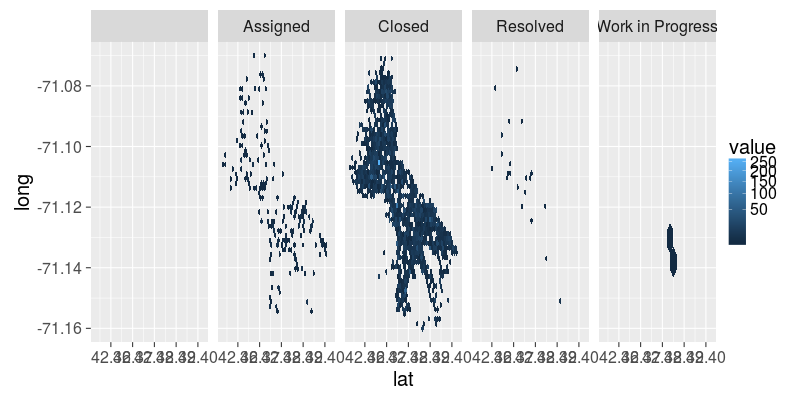

In [32]:
p = (gp.ggplot(ddataf) + 
     gp.geom_hex(gp.aes_string(x='lat', y='long'), bins=50) +
     gp.scale_fill_continuous(trans="sqrt") +
     gp.theme_gray(base_size=20) +
     gp.facet_grid('~Status'))
p

---

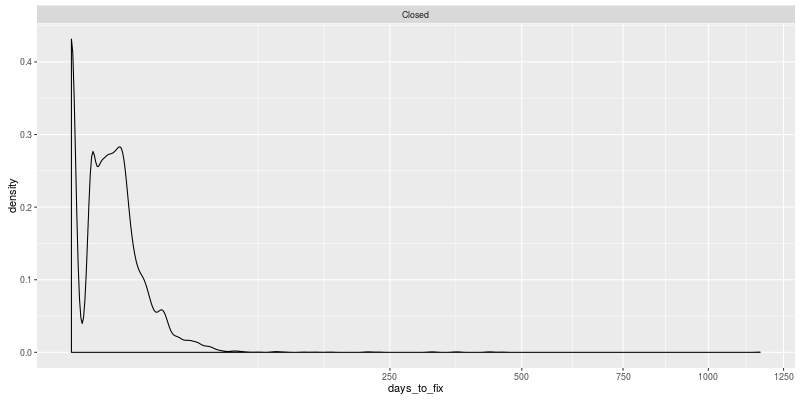

In [33]:
p = (gp.ggplot(ddataf.filter('Status == "Closed"')) + 
     gp.geom_density(gp.aes_string(x='days_to_fix')) +
     gp.facet_grid('~Status') +
     gp.scale_x_sqrt() +
     gp.theme(**{'legend.position': 'top'}))
p

---

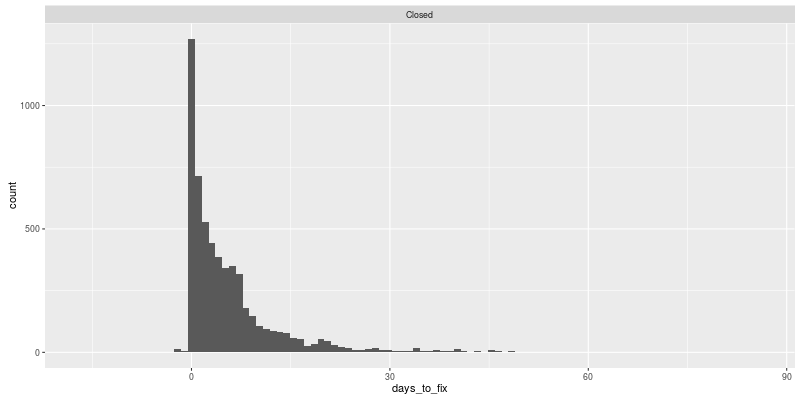

In [34]:
p = (gp.ggplot(ddataf.filter('Status == "Closed"',
                             'days_to_fix < 100')) + 
     gp.geom_histogram(gp.aes_string(x='days_to_fix'), bins=100) +
     gp.facet_grid('~Status') +
     gp.theme(**{'legend.position': 'top'}))
p

---

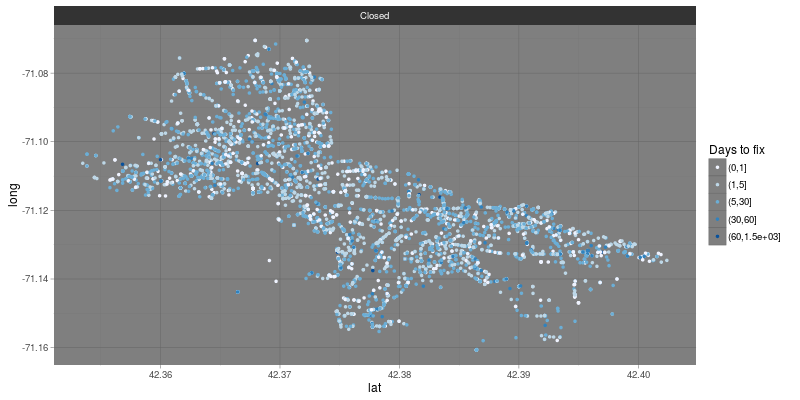

In [35]:
p = (gp.ggplot(ddataf.filter('Status == "Closed"')) + 
     gp.geom_point(gp.aes_string(x='lat', y='long',
                                 color='cut(days_to_fix, c(0,1,5,30,60,1500))'),
                  size=1) +
     gp.facet_grid('~Status') +
     gp.theme_dark() +
     gp.scale_color_brewer("Days to fix"))
p

---

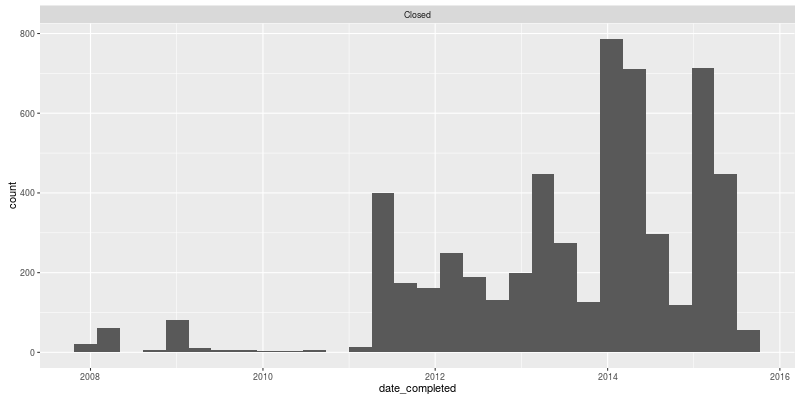

In [36]:
p = (gp.ggplot(ddataf.filter('Status == "Closed"')) + 
     gp.geom_histogram(gp.aes_string(x='date_completed'), bins=30) +
     gp.facet_grid('~Status') +
     gp.theme(**{'legend.position': 'top'}))
p

---

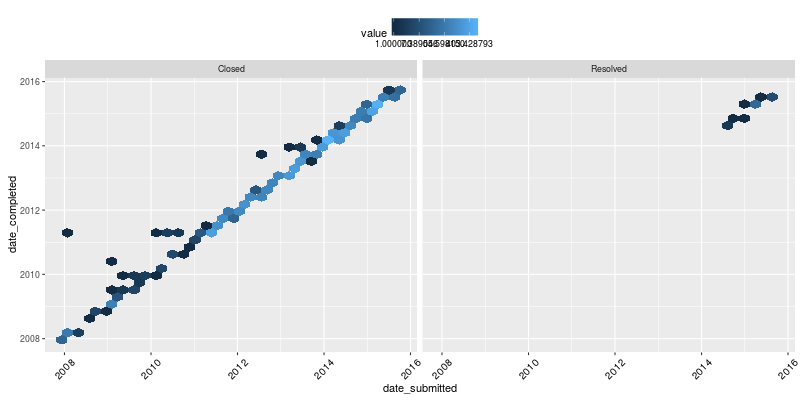

In [37]:
p = (gp.ggplot(ddataf.filter('Status %in% c("Closed", "Resolved")')) + 
     gp.geom_hex(gp.aes_string(x='date_submitted', y='date_completed')) +
     gp.facet_grid('~Status') +
     gp.scale_fill_continuous(trans="log") +
     gp.theme(**{'legend.position': 'top',
                 'axis.text.x': gp.element_text(angle = 45, hjust = .5)}))
p

---

In [38]:
extract_weekday = """
factor(weekdays(date_submitted),
       levels=c("Sunday", "Monday",
                "Tuesday", "Wednesday", "Thursday",
                "Friday", "Saturday"))
"""
# transition iPhone / iOS
ddataf = (ddataf.
          mutate(year_submitted='format(date_submitted, format="%Y")',
                 month_submitted='format(date_submitted, format="%m")',
                 weeknum_submitted='as.numeric( format(date_submitted+3, "%U"))',
                 weekday_submitted=(extract_weekday)).
	  filter('year_submitted >= 2012',
                 'Platform != ""'))

---

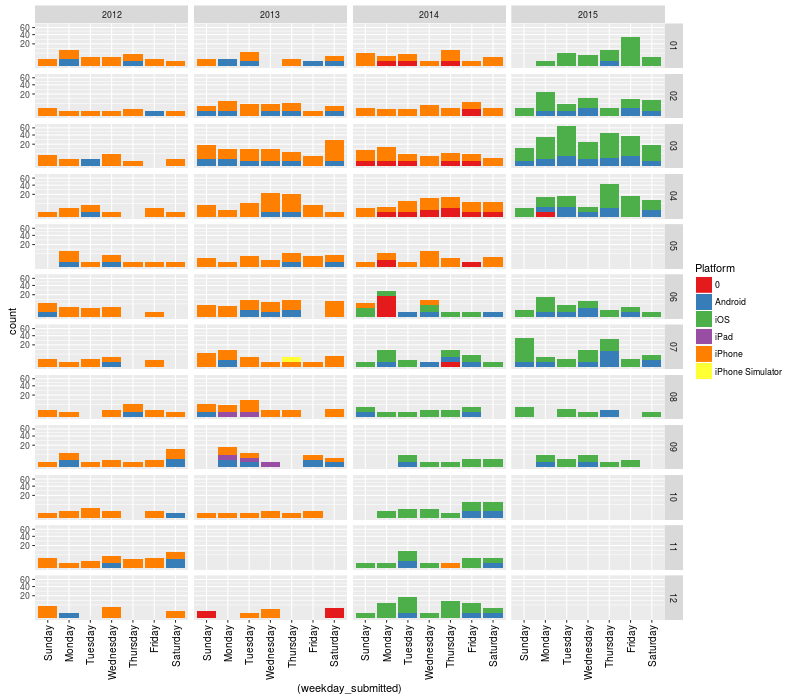

In [39]:
p = (gp.ggplot(ddataf) + 
     gp.geom_bar(gp.aes_string(x='(weekday_submitted)', fill='Platform')) +
     gp.scale_fill_brewer(palette = 'Set1') +
     gp.scale_y_sqrt() +
     gp.theme(**{'axis.text.x': gp.element_text(angle = 90, hjust = 1)}) +
     gp.facet_grid('month_submitted ~ year_submitted'))
display.Image(display_ggplot2(p, height=700))